In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib widget

## Vehicle Info
Wheelbase: 1.542m

In [2]:
wheelbase = 1.542

## Load data

In [3]:
PATH_DATA = Path("/mnt/c/Users/SauravTuladhar/OneDrive - Redpoint Positioning/RPP_OneDrive/data/Raymond/OdometryData")

df_odo_raw = pd.read_excel(PATH_DATA/"tag_sync_loss_test_1.xlsx", sheet_name='in')

In [4]:
df_odo_raw.columns

Index(['dt_sec', ' t_velocity (1/10 MPH)', ' t_steer (1/100 Degree)',
       ' on_wire (True/False)', ' rtls_x (m)', ' rtls_y (m)', ' rtls_pos (ID)',
       ' rtls_uloc (True/False)'],
      dtype='object')

### Pre-process
- Unit conversion
- Calculate turn rate
  - Turn radius r = $l\sin(90 - \phi)/\sin(\phi)$  provided by Anthony
  - 
  - Based on Anthony's comment
- Label rename

**Turn rate**
$ \omega = \frac{s\sin(\phi)}{l}$

In [5]:
MPS2MPH = 2.237
RAD2DEG = 180/np.pi
DEG2RAD = 1/RAD2DEG

df_odo_units = (df_odo_raw
                .assign(tsec=lambda df_:df_.dt_sec.cumsum()-df_.dt_sec.iloc[0],
                       speed=lambda df_:df_[' t_velocity (1/10 MPH)']*0.1/MPS2MPH,  # to m/s
                        steer=lambda df_:df_[' t_steer (1/100 Degree)']*0.01,       # to degrees
                        turnrate=lambda df_:np.sin(df_.steer*DEG2RAD)*(df_.speed)*RAD2DEG/(wheelbase),   # turn rate
                        #turnrate=lambda df_:np.sin(df_.steer*DEG2RAD)*(df_.speed)*RAD2DEG/(wheelbase*np.sin((90 - df_.steer)*DEG2RAD)),   # turn rate
                        x_pos = lambda df_:df_[' rtls_x (m)'],
                       y_pos = lambda df_:df_[' rtls_y (m)'])
                .drop(columns=[' t_velocity (1/10 MPH)', ' rtls_x (m)', ' rtls_y (m)'])
               )

**Data frequency**

In [6]:
print(f"Data frequency is {1/df_odo_units['dt_sec'].median():.2f}Hz")

Data frequency is 15.21Hz


## Visualize

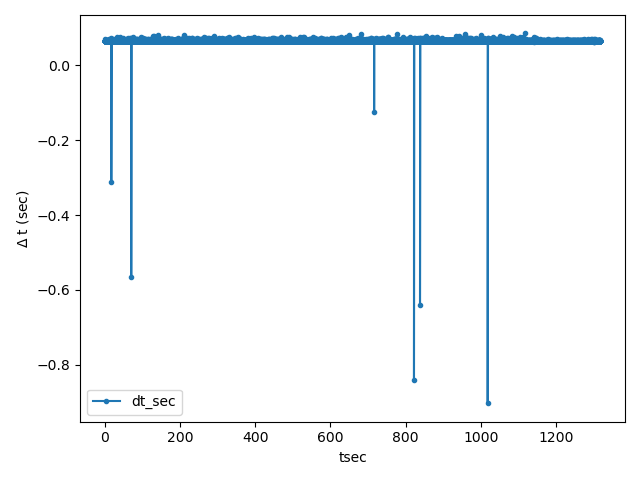

In [7]:
fig, ax = plt.subplots()
df_odo_units.shift(-1).plot('tsec', 'dt_sec', marker='.', ax=ax)
ax.set(ylabel="$\Delta$ t (sec)")
fig.tight_layout()

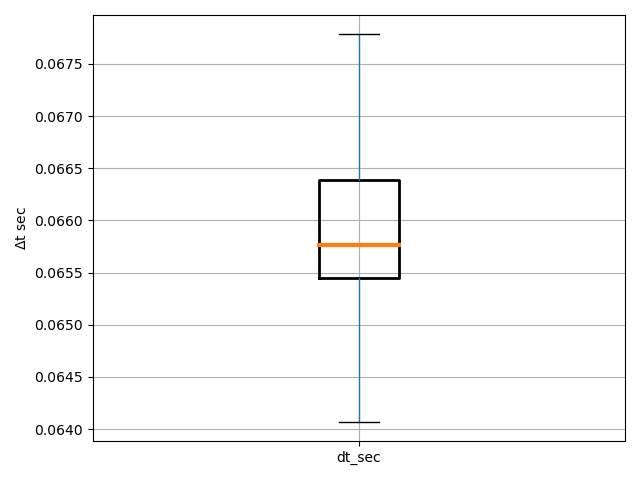

In [8]:
boxprops = dict(linestyle='-', linewidth=2)
medianprops = dict(linewidth=3)
fig, ax = plt.subplots()
df_odo_units.shift(-1).boxplot('dt_sec', 
                               showfliers=False, 
                               boxprops=boxprops, medianprops=medianprops,
                               ax=ax)
ax.set(ylabel="$\Delta$t sec")
fig.tight_layout()

### Position trace

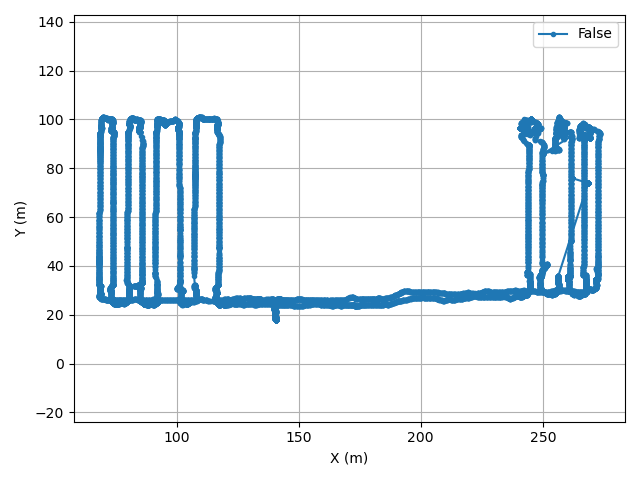

In [9]:
fig, ax = plt.subplots()
df_odo_units.plot('x_pos', 'y_pos', marker='.',
                  label=False,
                  ax=ax);
ax.axis('equal')
ax.set(xlabel='X (m)', ylabel='Y (m)')
ax.grid(True)
fig.tight_layout()

### Odometry timeseries

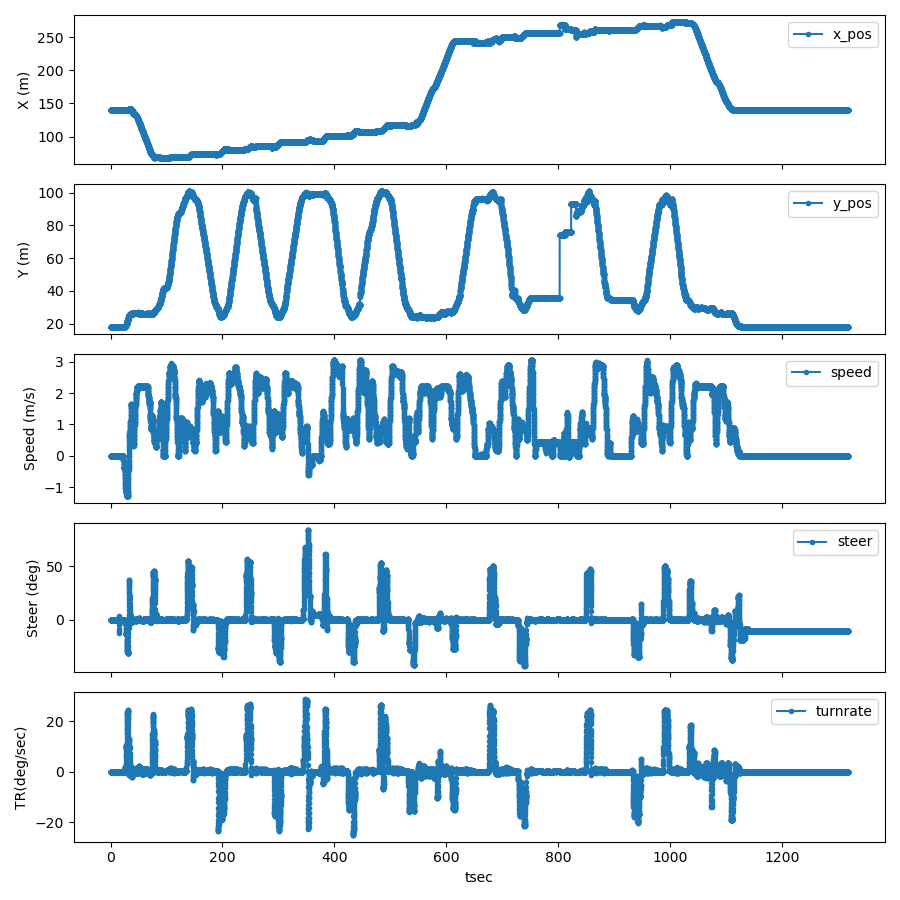

In [10]:
# plt.rcParams['axes.grid'] = True
fig, (axx, axy, ax_speed, ax_steer, ax_tr) = plt.subplots(figsize=(9, 9), nrows=5, sharex=True)
df_odo_units.plot('tsec', 'x_pos', marker='.', ax=axx);
axx.set(ylabel='X (m)')

df_odo_units.plot('tsec', 'y_pos', marker='.', ax=axy);
axy.set(ylabel='Y (m)')

df_odo_units.plot('tsec', 'speed', marker='.', ax=ax_speed);
ax_speed.set(ylabel='Speed (m/s)')
df_odo_units.plot('tsec', 'steer', marker='.', ax=ax_steer);
ax_steer.set(ylabel='Steer (deg)')
df_odo_units.plot('tsec', 'turnrate', marker='.', ax=ax_tr);
ax_tr.set(ylabel='TR(deg/sec)');
fig.tight_layout()


### Sample interval
- Select interval where truck is expected to be moving in a straight line i.e. likely inside an aisle

In [11]:
df_odo_sample = (df_odo_units
                 # .query("tsec>310 & tsec<340")  # Interval 1
                 # .query("tsec>620 & tsec<650")  # Interval 2
                 .query("tsec>265 & tsec<285")    # Interval 3
               )

**Steer angle mean and stddev**

In [12]:
print(f"Steer angle mean {df_odo_sample['steer'].mean():.2f} and stddev: {df_odo_sample['steer'].std():.2f}")

Steer angle mean 0.22 and stddev: 0.22


**Speed mean and stddev**

In [13]:
df_odo_sample = (df_odo_units
                 .query("tsec>762 & tsec<776")           # Interval 1
                 # .query("tsec>50 & tsec<65")           # Interval 2
                 # .query("tsec>1050 & tsec<1070")       # Interval 3
               )

In [14]:
print(f"Speed mean {df_odo_sample['speed'].mean():.2f} and stddev: {df_odo_sample['speed'].std():.2f}")

Speed mean 0.43 and stddev: 0.02


### Sanity check
Check if integrating turn rate at the end of the aisles gives ~180

In [38]:
df_odo_turn = (df_odo_units
               .query("tsec>470 & tsec<500")
               # .query("tsec>986 & tsec<1000")
               .assign(angle=lambda df_:np.cumsum(df_.turnrate*df_.dt_sec))
               
               )

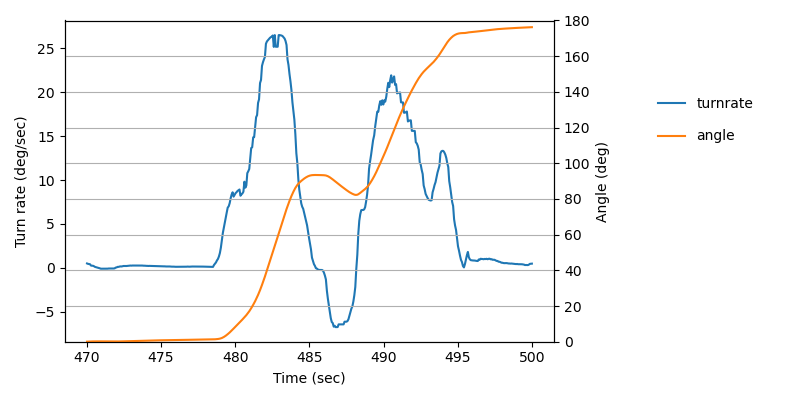

In [39]:
fig, ax_tr = plt.subplots(figsize=(8, 4))
df_odo_turn.plot('tsec', 'turnrate', ax=ax_tr);
ax_tr.set(ylabel='Turn rate (deg/sec)', xlabel='Time (sec)')
ax_tr.legend(loc='lower left', bbox_to_anchor= (1.2, 0.7), ncol=1,
            borderaxespad=0, frameon=False)
ax_angle = ax_tr.twinx()
df_odo_turn.plot('tsec', 'angle', c='tab:orange', ax=ax_angle);
ax_angle.set(ylabel='Angle (deg)', ylim=[0, 180])
ax_angle.grid(True)
ax_angle.legend(loc='lower left', bbox_to_anchor= (1.2, 0.6), ncol=1,
            borderaxespad=0, frameon=False)
fig.tight_layout()